In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext line_profiler

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import pathlib
from functools import partial

import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble']=r"\usepackage{bm}"
import plotly.express as px
import plotly.graph_objects as go

In [3]:
import jax
import jax.numpy as jnp
# jax.config.update("jax_enable_x64", True)
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])
# jax.config.update('jax_platform_name', 'cpu')

import diffrax
import equinox as eqx
import optax

from haiku import PRNGSequence

In [4]:
import exciting_environments as excenvs

import dmpe
from dmpe.models import NeuralEulerODEPendulum, NeuralODEPendulum, NeuralEulerODE, NeuralEulerODECartpole
from dmpe.models.model_utils import simulate_ahead_with_env
from dmpe.models.model_training import ModelTrainer
from dmpe.excitation import loss_function, Exciter

from dmpe.utils.density_estimation import (
    update_density_estimate_single_observation, update_density_estimate_multiple_observations, DensityEstimate, select_bandwidth
)
from dmpe.utils.signals import aprbs
from dmpe.evaluation.plotting_utils import (
    plot_sequence, append_predictions_to_sequence_plot, plot_sequence_and_prediction, plot_model_performance
)
from dmpe.evaluation.experiment_utils import (
    get_experiment_ids, load_experiment_results, quick_eval, evaluate_experiment_metrics, evaluate_algorithm_metrics, evaluate_metrics
)

2024-09-30 14:28:42.762434: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


---

In [5]:
# setup PRNG
key = jax.random.PRNGKey(seed=222)

data_key, model_key, loader_key, expl_key, key = jax.random.split(key, 5)
data_rng = PRNGSequence(data_key)

In [6]:
from exciting_environments.pmsm.pmsm_env import PMSM

In [7]:
batch_size=1

env = PMSM(
    batch_size=batch_size,
    saturated=True,
    static_params = {
        "p": 3,
        "r_s": 1,
        "l_d": 0.37e-3,
        "l_q": 1.2e-3,
        "psi_p": 65.6e-3,
        "deadtime": 0,
    }
)

In [8]:
act=jnp.repeat(jnp.array([0.03,0.03])[:,None],batch_size,axis=1).T
act.shape

(1, 2)

In [9]:
obs, state = env.reset()

n_steps = 99
actions = jnp.concatenate([aprbs(n_steps, batch_size, 1, 10, next(data_rng)), aprbs(n_steps, batch_size, 1, 10, next(data_rng))], axis=-1)

observations = [obs[..., 0:2]]

for i in range(actions.shape[1]):
   
    obs, state = env.vmap_step(state, actions[:, i,:])
    observations.append(obs[...,0:2])

(<Figure size 1800x600 with 3 Axes>,
 array([<Axes: title={'center': 'observations, timeseries'}, xlabel='$t$ in seconds', ylabel='$\\bm{x}$'>,
        <Axes: title={'center': 'observation plane'}, xlabel='i_d', ylabel='i_q'>,
        <Axes: title={'center': 'actions, timeseries'}, xlabel='$t$ in seconds', ylabel='$\\bm{u}$'>],
       dtype=object))

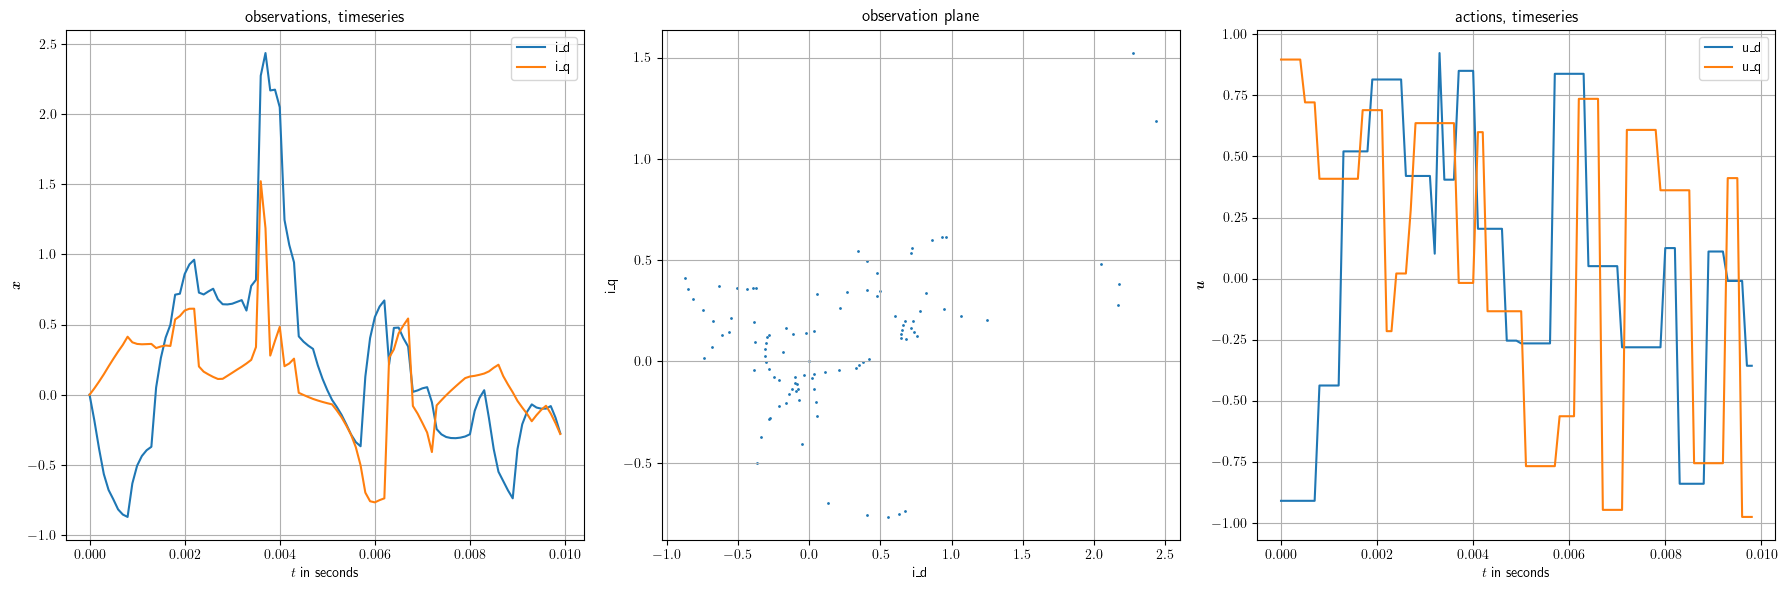

In [10]:
plot_sequence(np.concatenate(observations), np.concatenate(actions), env.tau, obs_labels=env.obs_description[:2], action_labels=['u_d', 'u_q'])

In [11]:
from dmpe.algorithms import excite_with_dmpe, default_dmpe

  0%|▉                                                                                                                                                                                                                                                                                        | 51/15000 [00:08<27:27,  9.08it/s]/home/hvater@uni-paderborn.de/venvs/jax-dev-base_311/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3042: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/home/hvater@uni-paderborn.de/venvs/jax-dev-base_311/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3043: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and wi

last input opt loss: 0.3673256
current data loss: 0.3597207


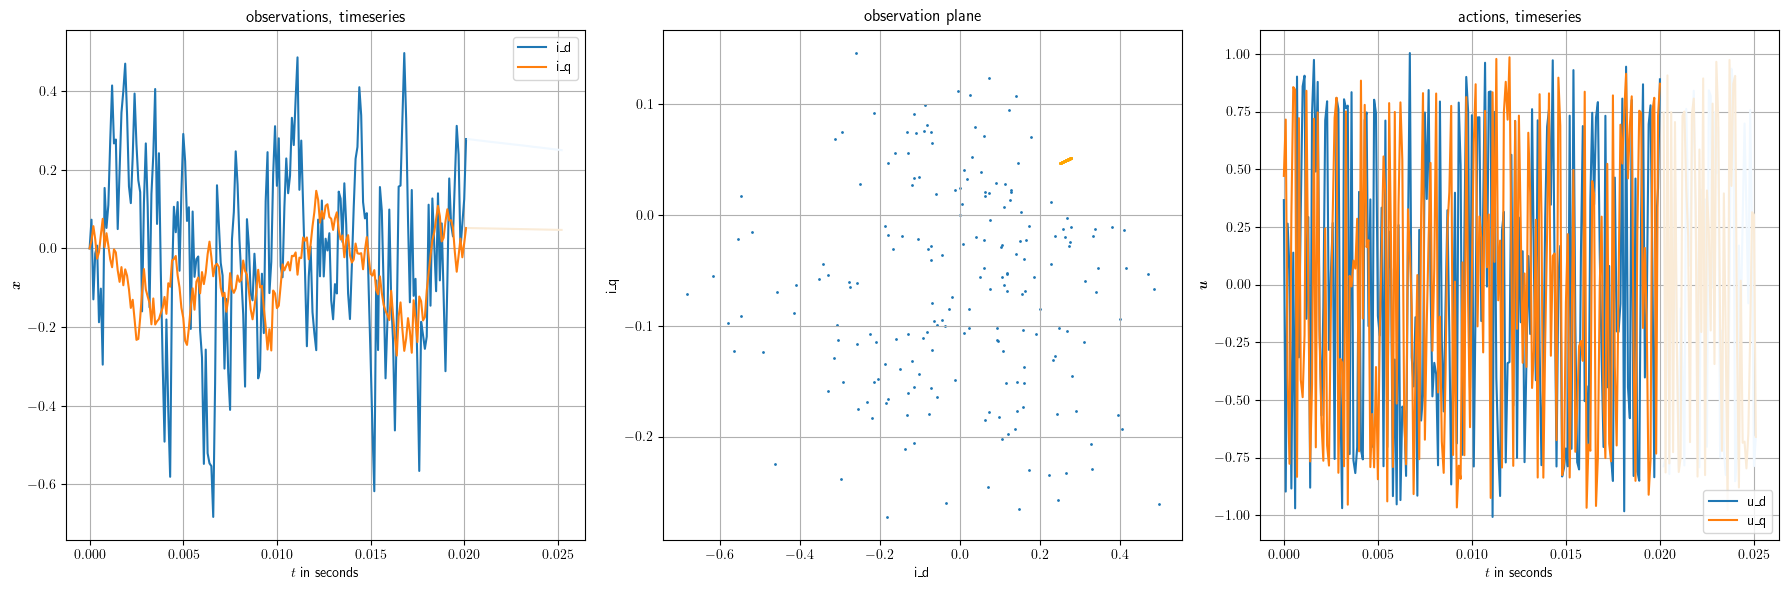

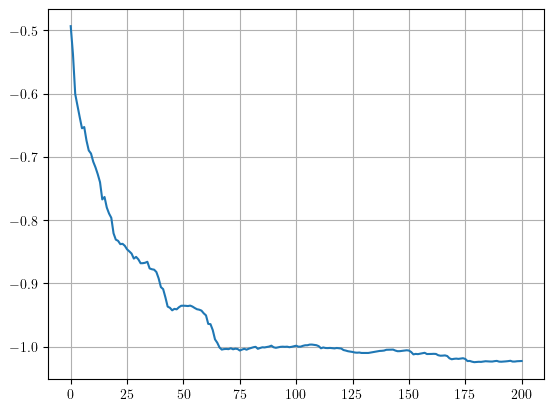

  3%|███████▍                                                                                                                                                                                                                                                                                | 400/15000 [00:51<29:27,  8.26it/s]

last input opt loss: 0.34522814
current data loss: 0.33987135


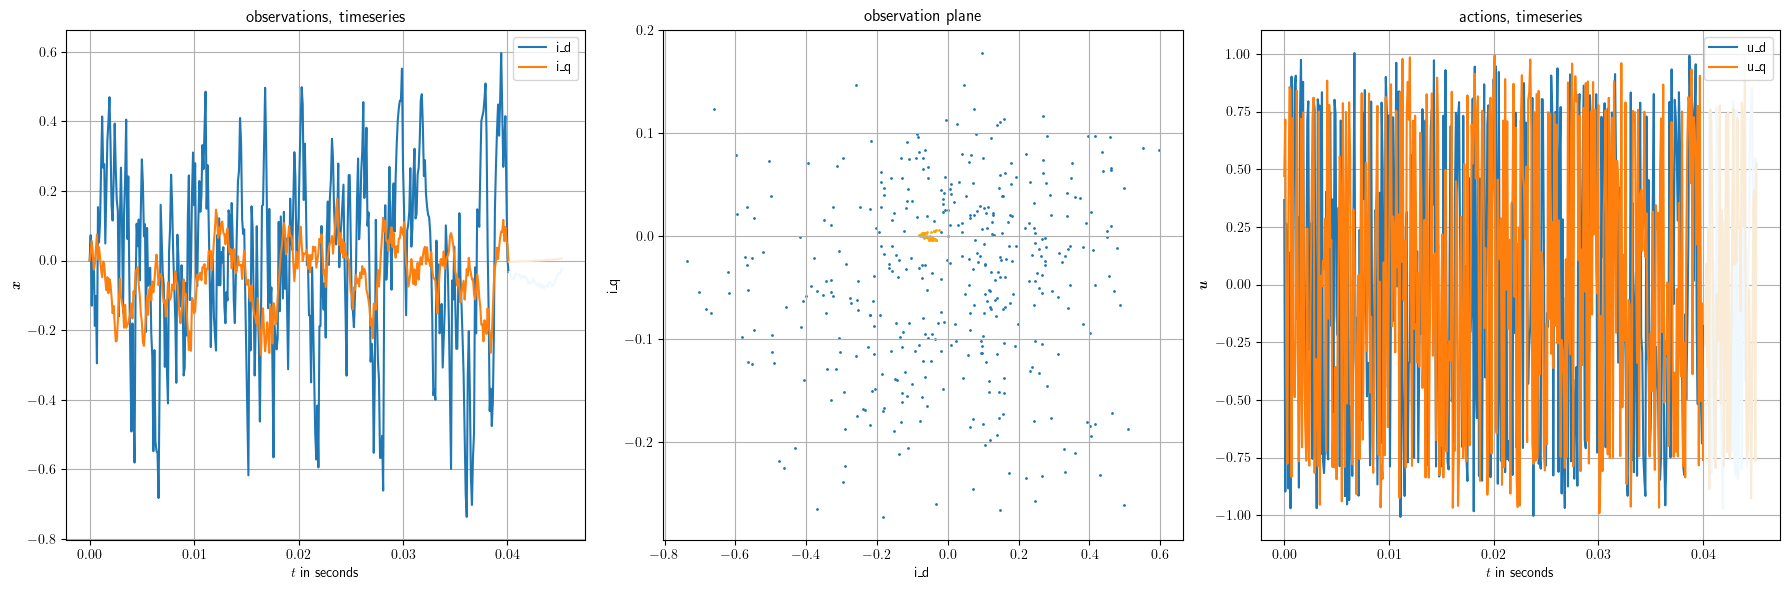

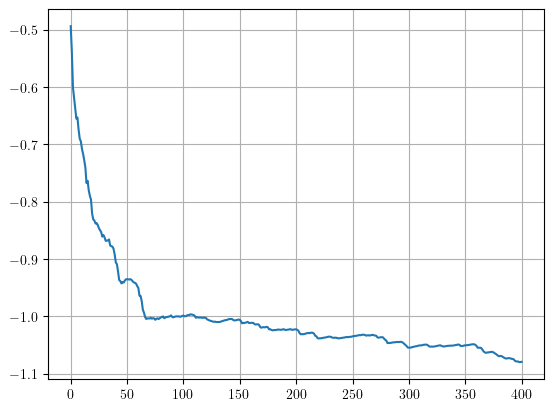

  4%|███████████▏                                                                                                                                                                                                                                                                            | 600/15000 [01:16<29:21,  8.17it/s]

last input opt loss: 0.32198006
current data loss: 0.32071066


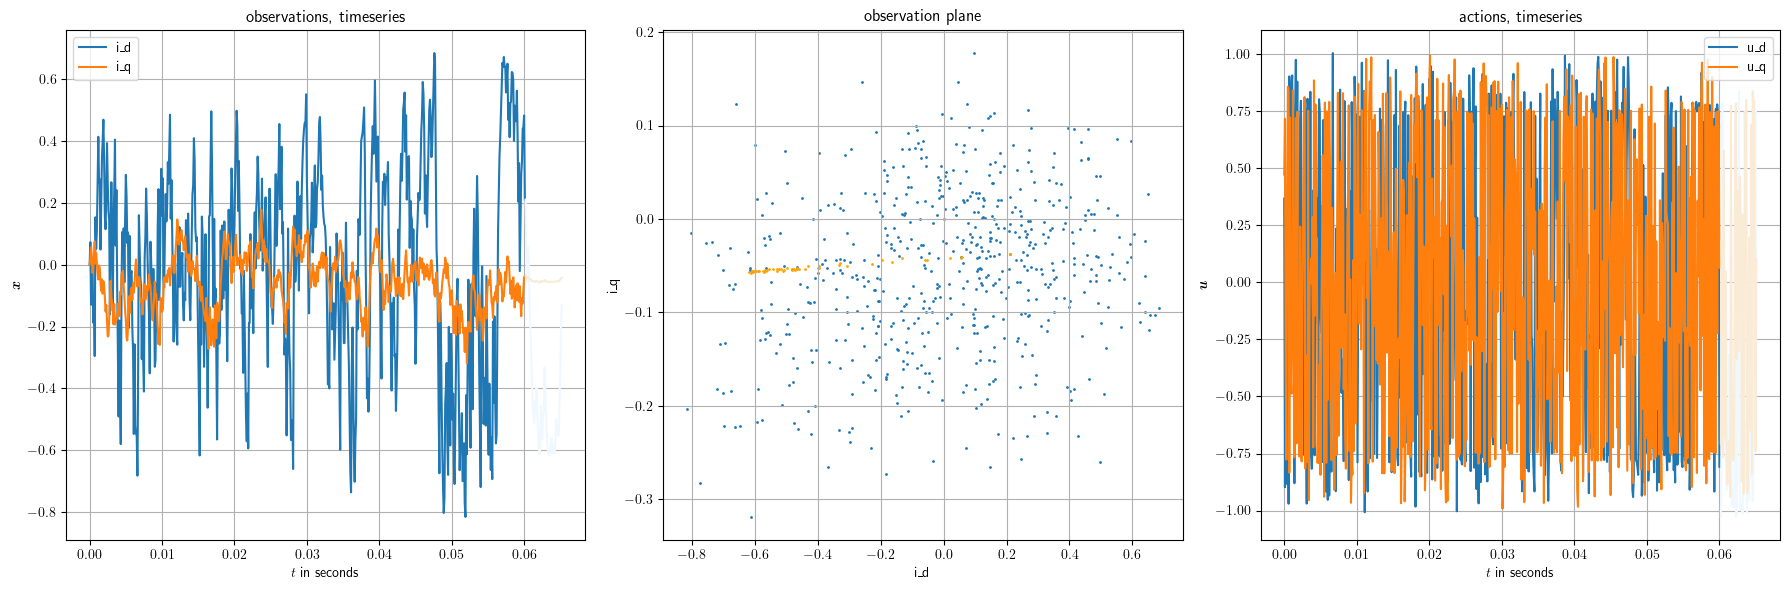

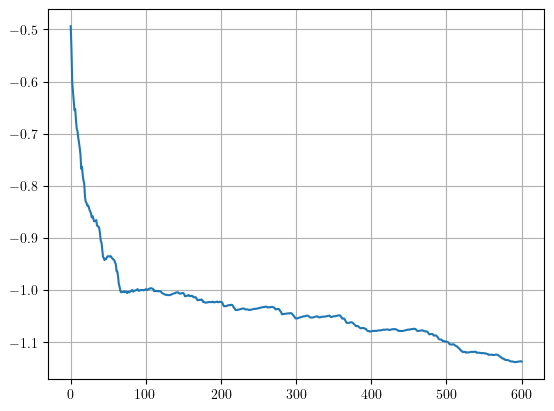

  5%|██████████████▉                                                                                                                                                                                                                                                                         | 800/15000 [01:41<29:06,  8.13it/s]

last input opt loss: 0.3038556
current data loss: 0.30558562


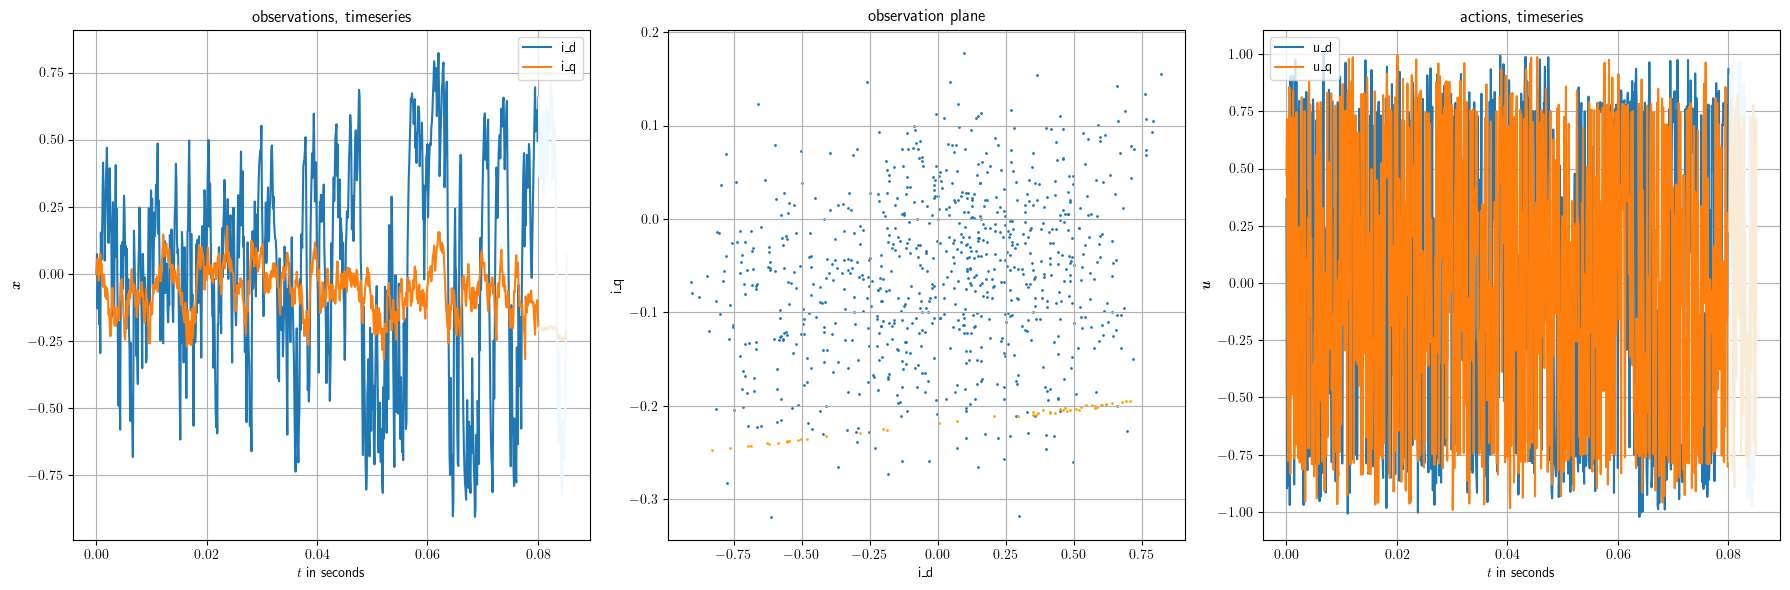

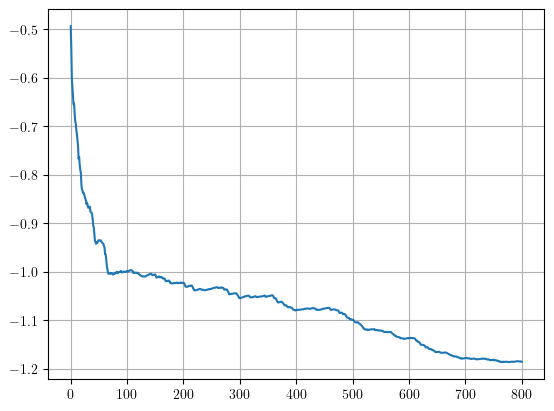

  7%|██████████████████▌                                                                                                                                                                                                                                                                    | 1000/15000 [02:07<28:56,  8.06it/s]

last input opt loss: 0.29980654
current data loss: 0.30040407


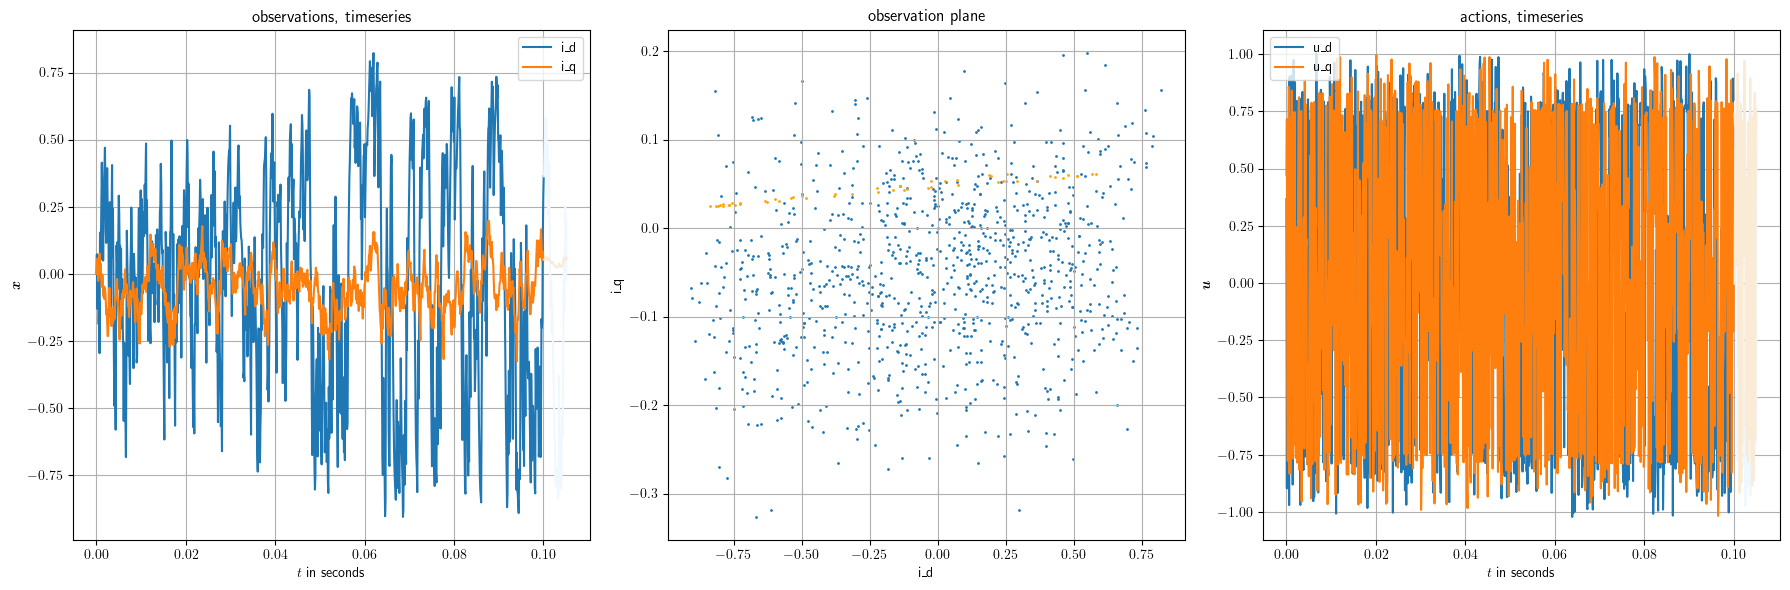

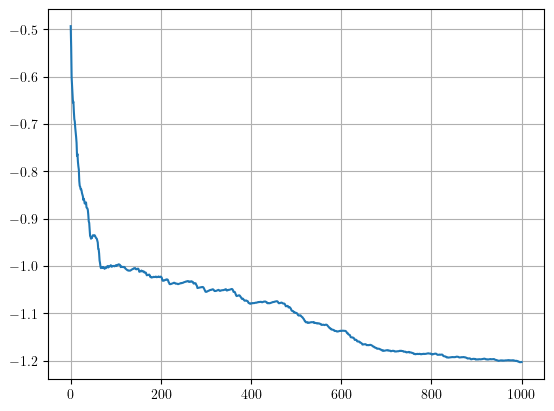

  8%|██████████████████████▎                                                                                                                                                                                                                                                                | 1200/15000 [02:32<28:26,  8.08it/s]

last input opt loss: 0.29457167
current data loss: 0.29447573


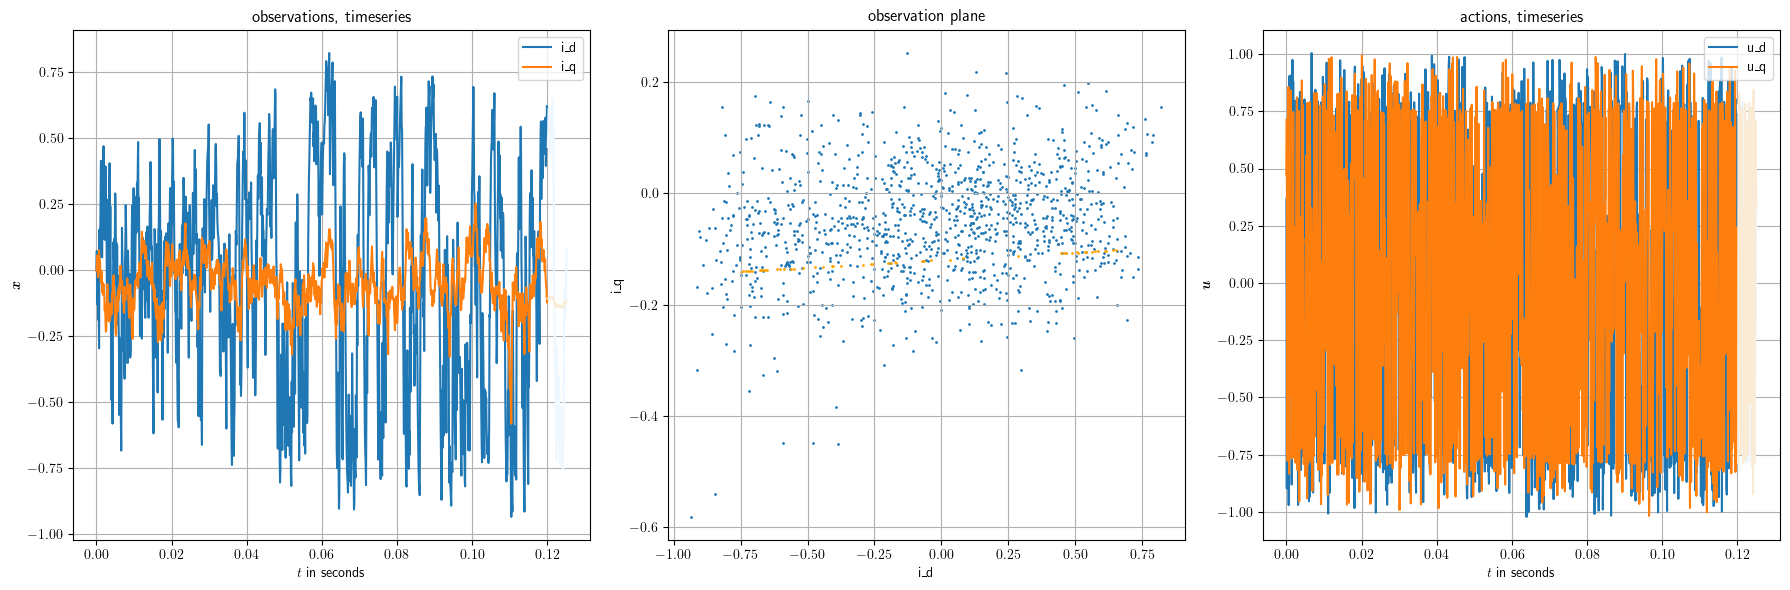

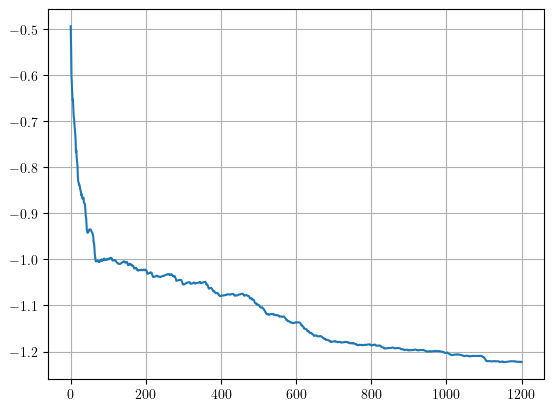

  9%|██████████████████████████                                                                                                                                                                                                                                                             | 1400/15000 [02:57<28:02,  8.09it/s]

last input opt loss: 0.26936457
current data loss: 0.2847926


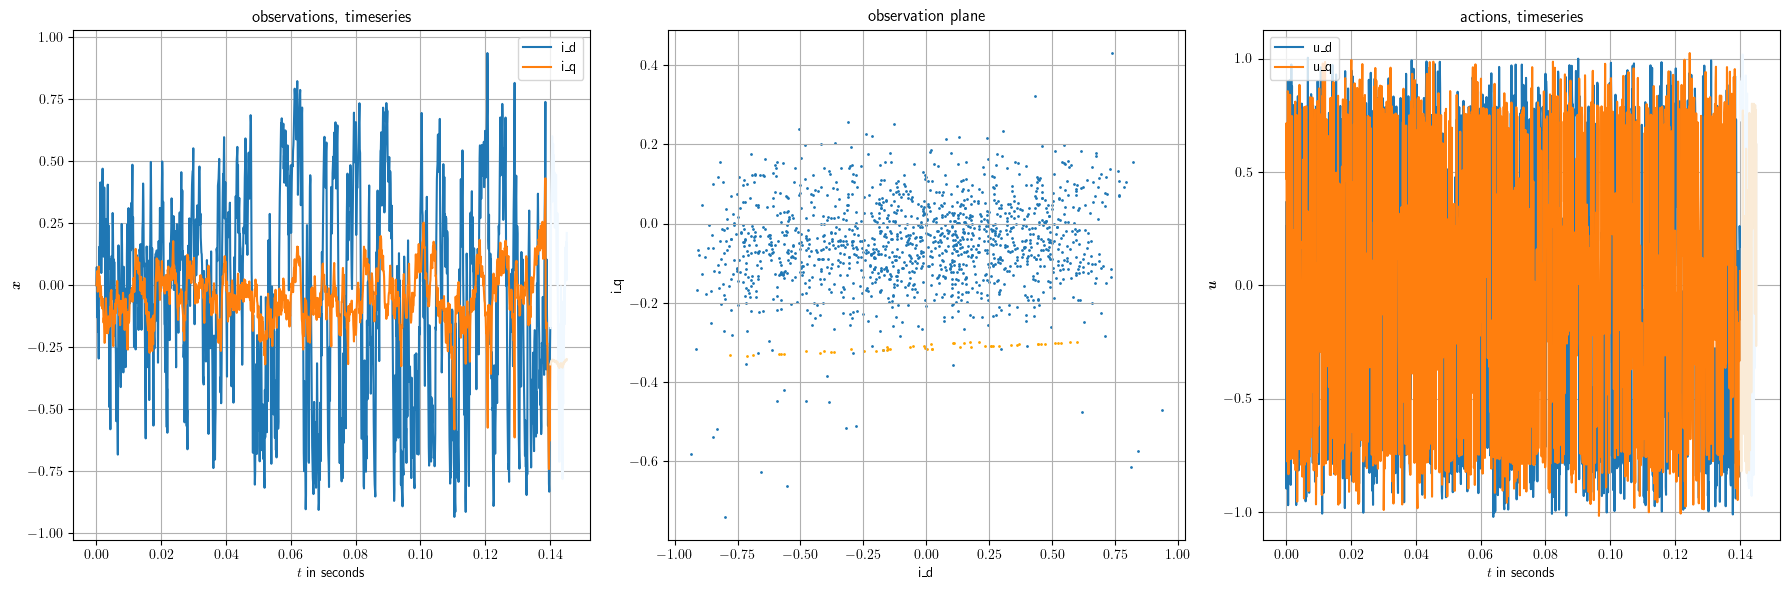

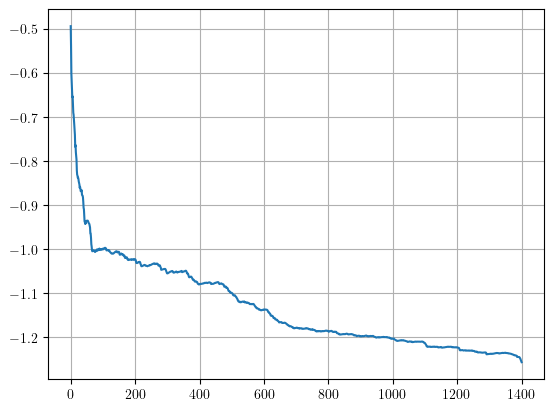

 11%|█████████████████████████████▊                                                                                                                                                                                                                                                         | 1600/15000 [03:23<27:39,  8.07it/s]

last input opt loss: 0.26984853
current data loss: 0.26982617


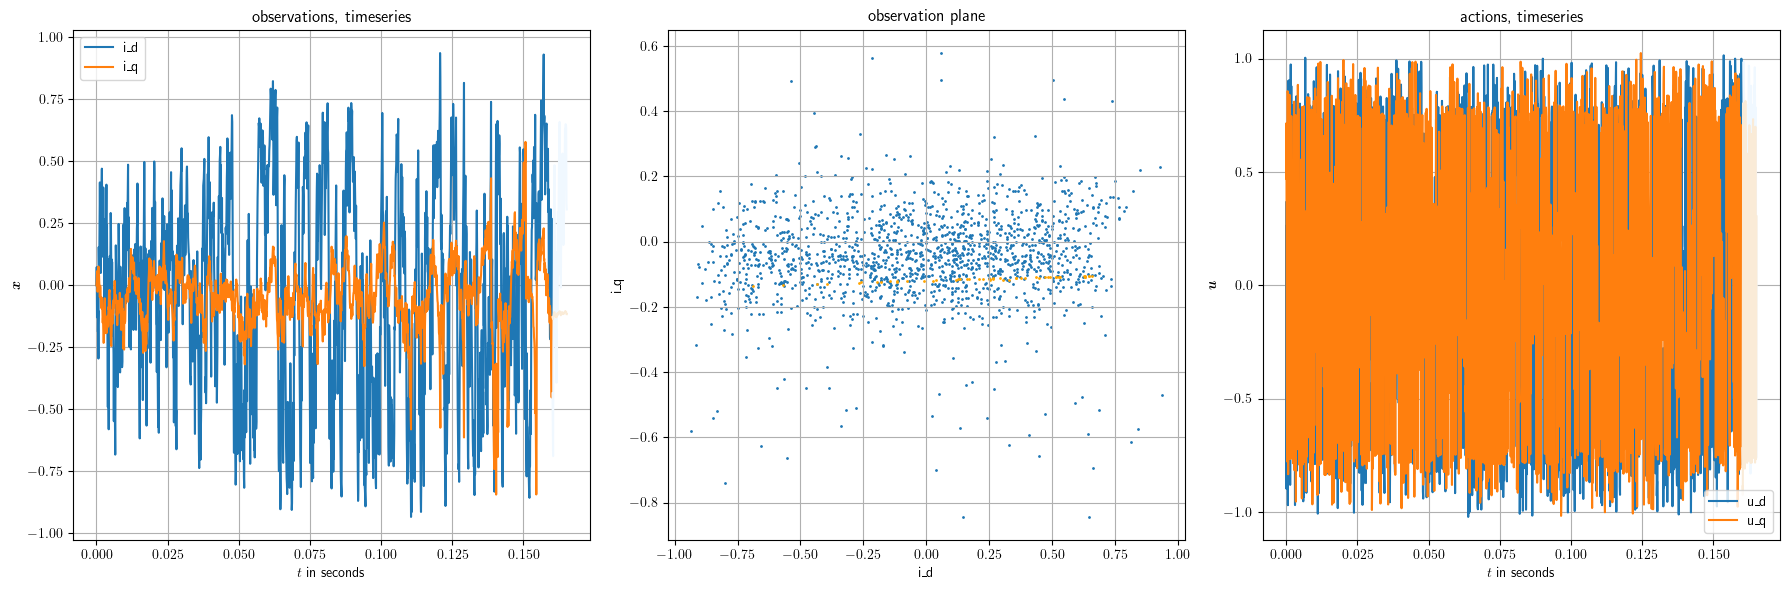

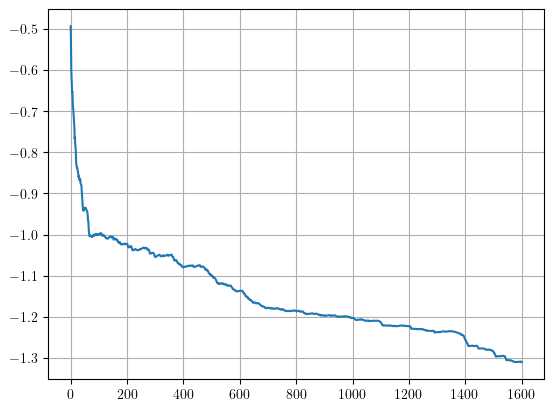

 12%|█████████████████████████████████▍                                                                                                                                                                                                                                                     | 1800/15000 [03:48<27:14,  8.08it/s]

last input opt loss: 0.23659715
current data loss: 0.24421382


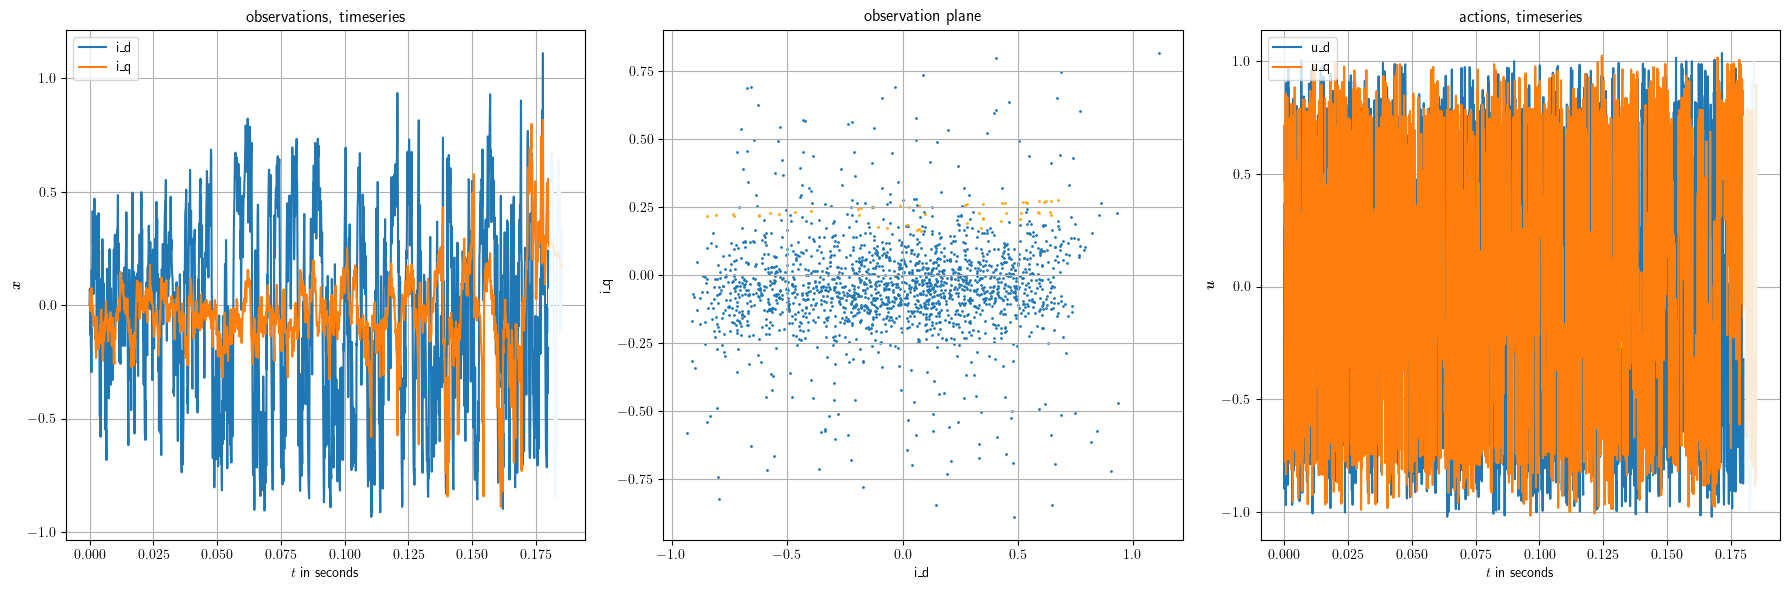

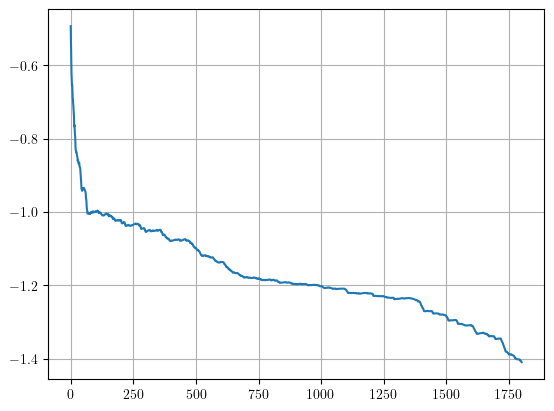

 13%|█████████████████████████████████████▏                                                                                                                                                                                                                                                 | 2000/15000 [04:13<26:51,  8.07it/s]

last input opt loss: 0.2228874
current data loss: 0.22825272


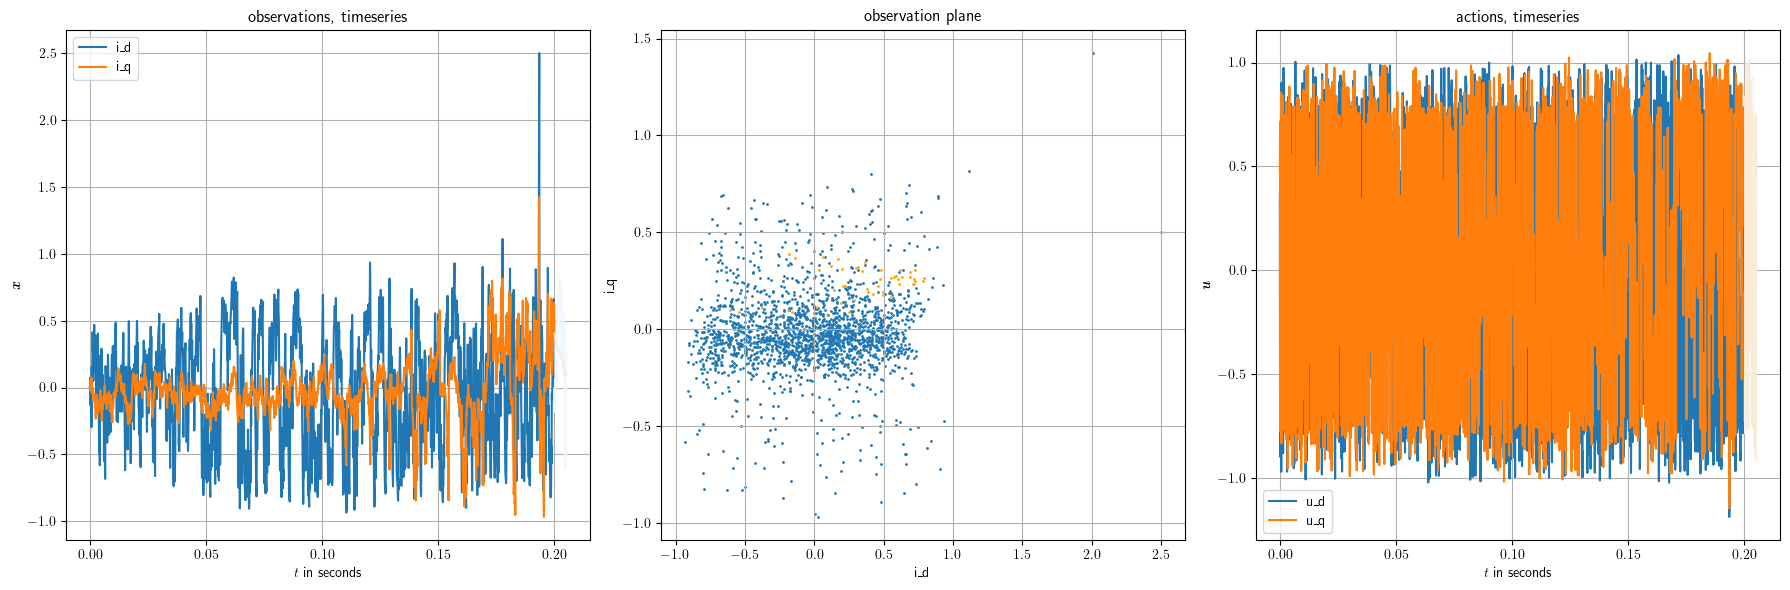

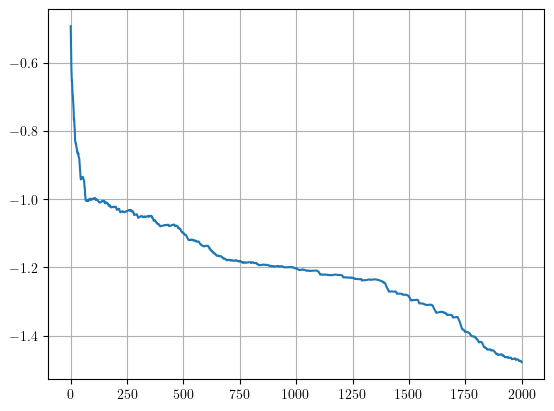

 15%|████████████████████████████████████████▉                                                                                                                                                                                                                                              | 2200/15000 [04:39<25:56,  8.22it/s]

last input opt loss: 2498285.0
current data loss: 0.22206396


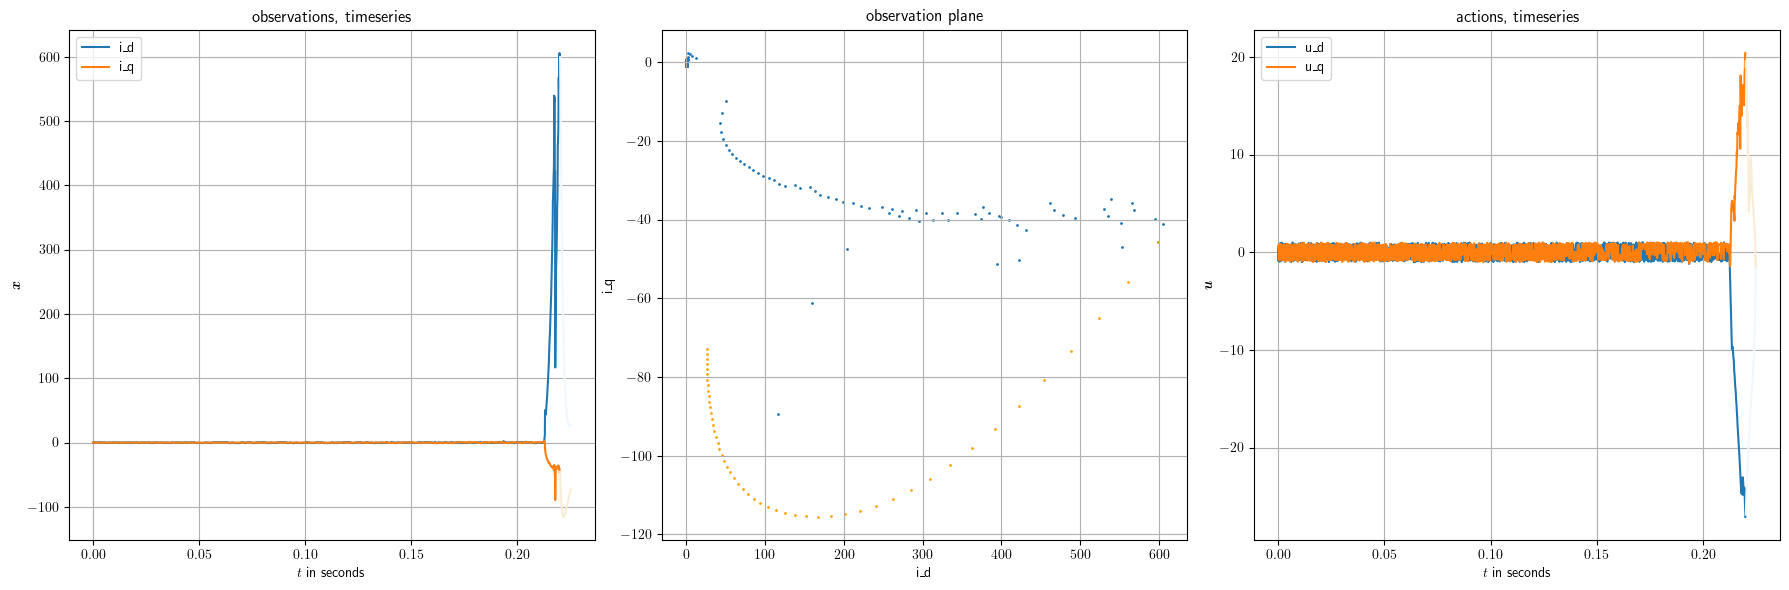

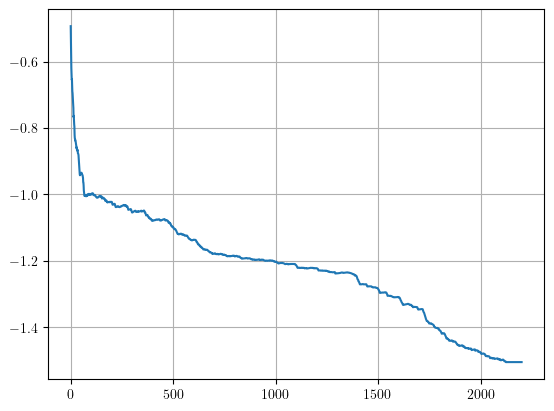

 16%|████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 2400/15000 [05:03<25:25,  8.26it/s]

last input opt loss: nan
current data loss: nan


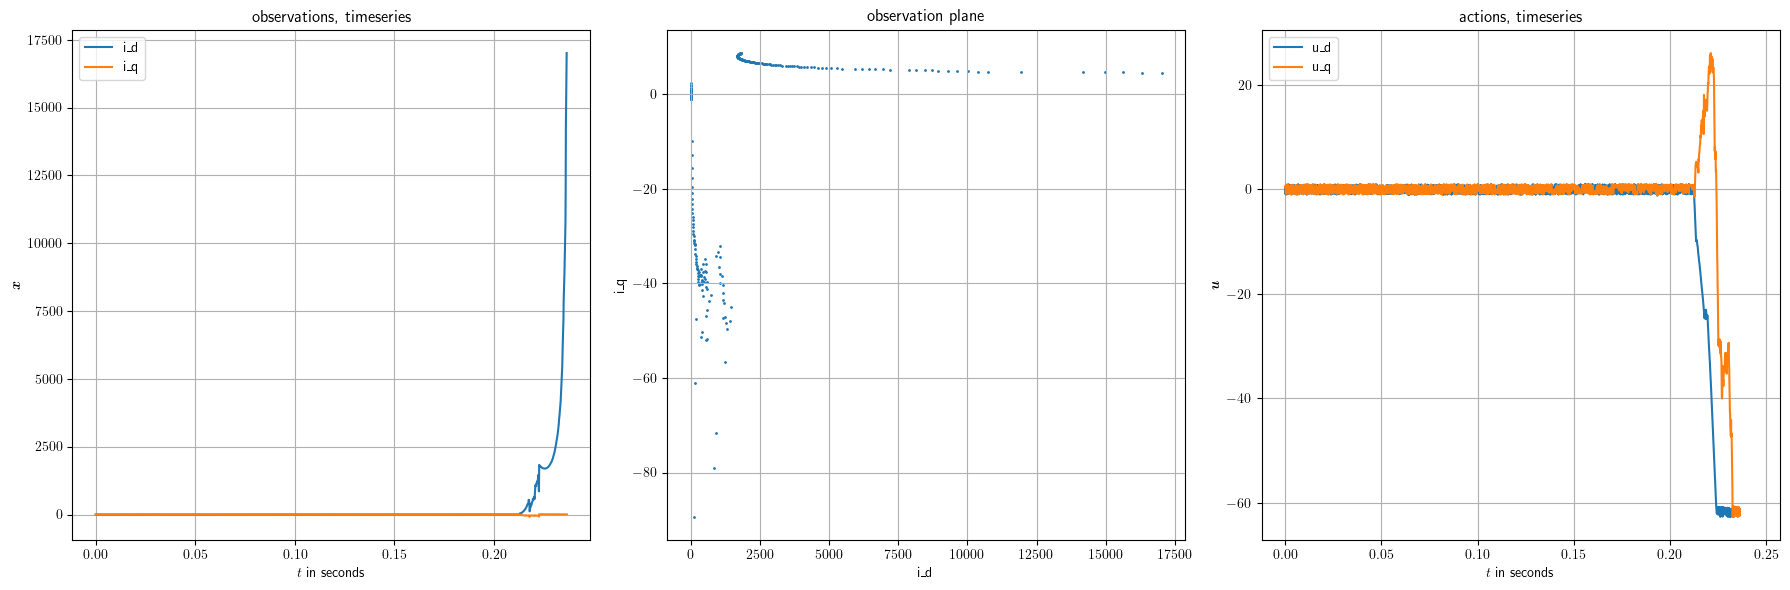

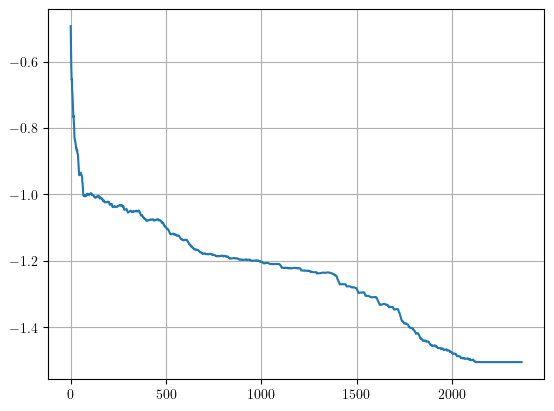

 17%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 2600/15000 [05:28<25:00,  8.26it/s]

last input opt loss: nan
current data loss: nan


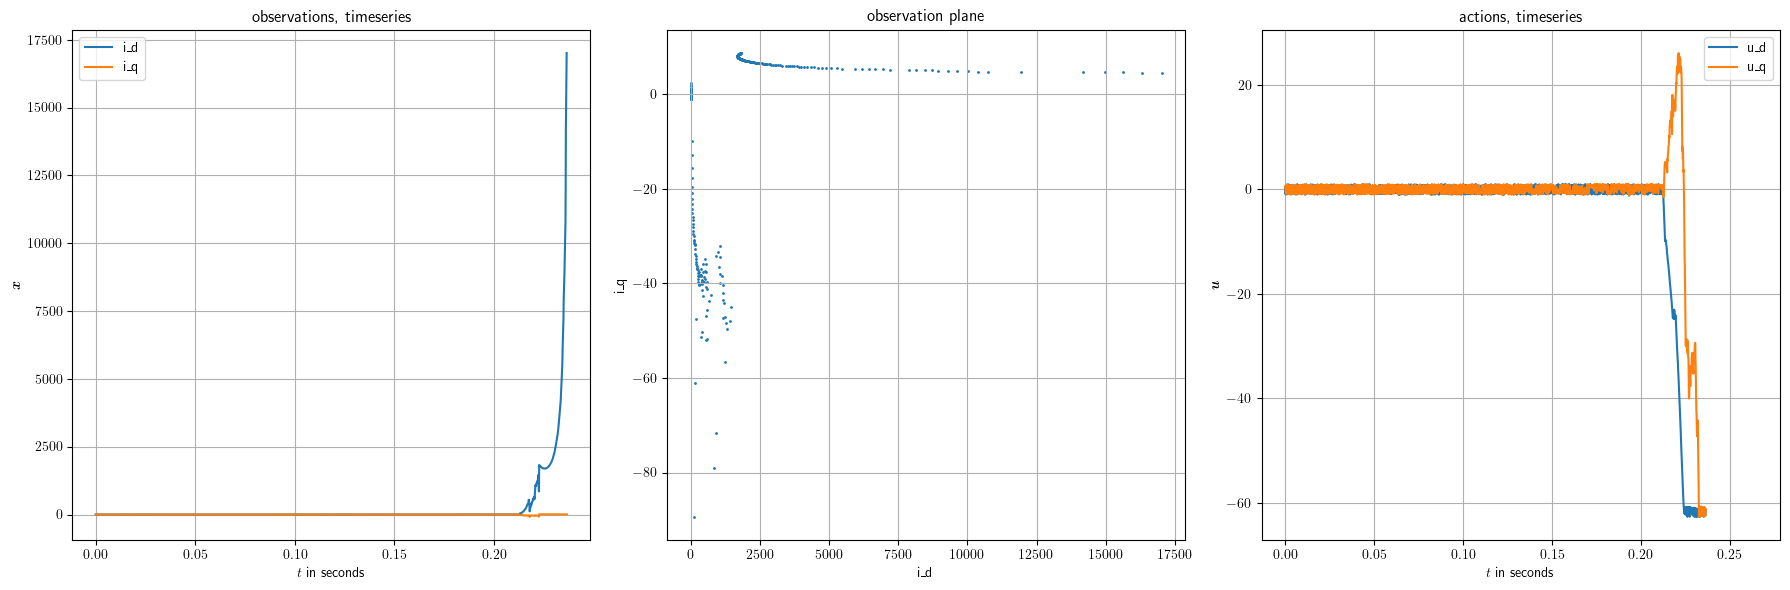

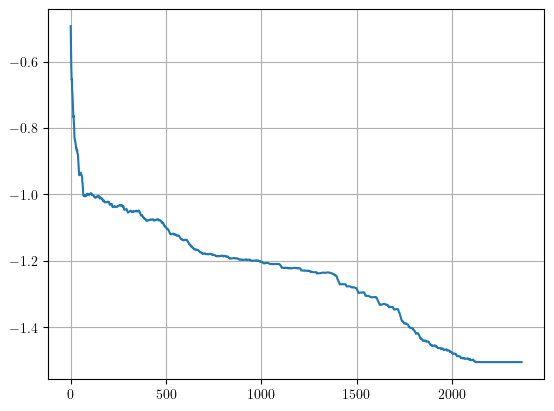

 19%|████████████████████████████████████████████████████                                                                                                                                                                                                                                   | 2800/15000 [05:53<24:35,  8.27it/s]

last input opt loss: nan
current data loss: nan


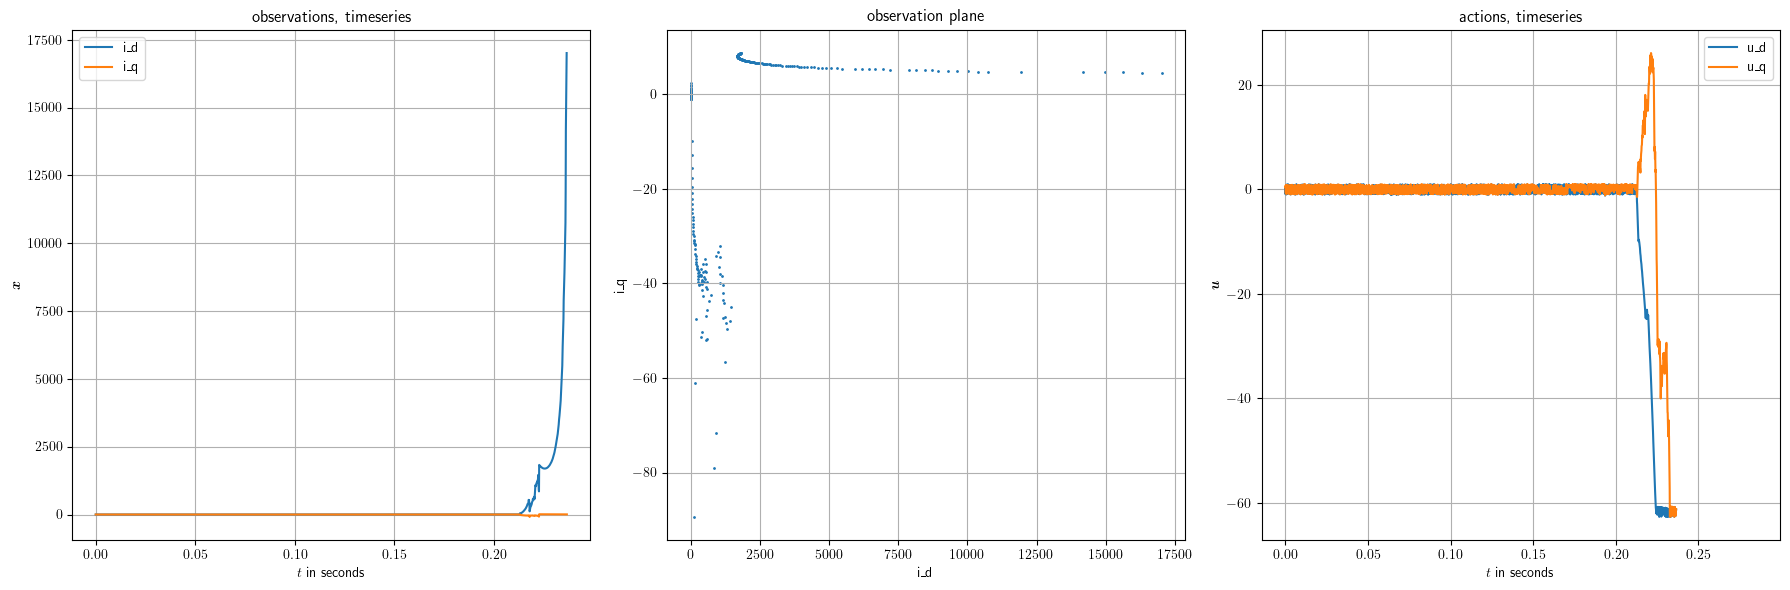

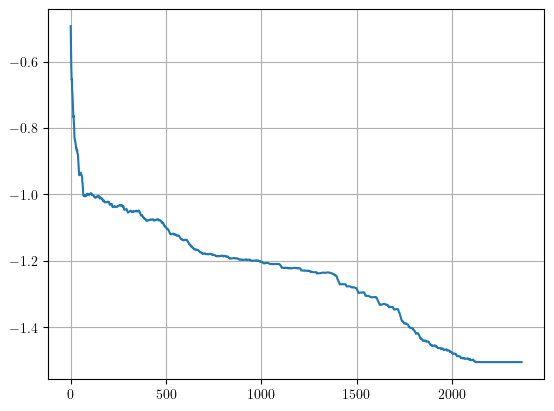

 20%|███████████████████████████████████████████████████████▊                                                                                                                                                                                                                               | 3000/15000 [06:18<24:13,  8.25it/s]

last input opt loss: nan
current data loss: nan


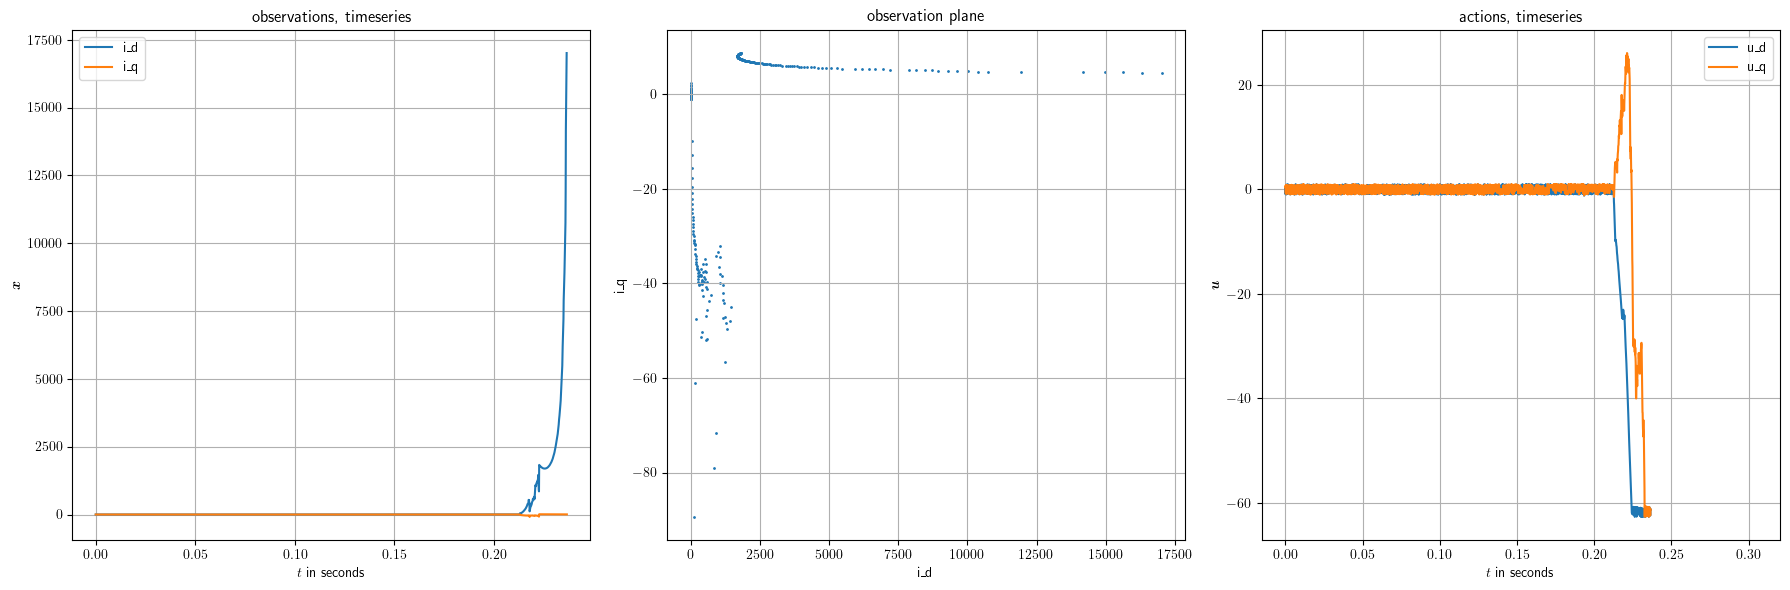

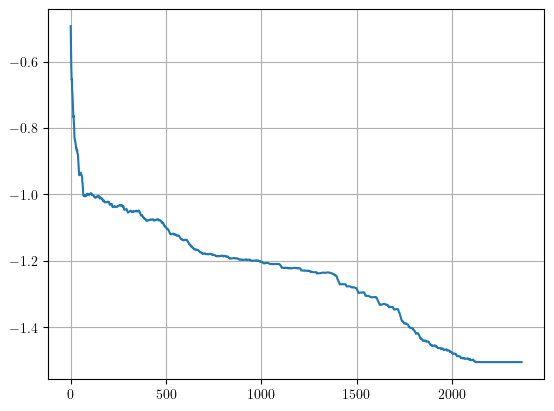

 21%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 3200/15000 [06:42<23:49,  8.26it/s]

last input opt loss: nan
current data loss: nan


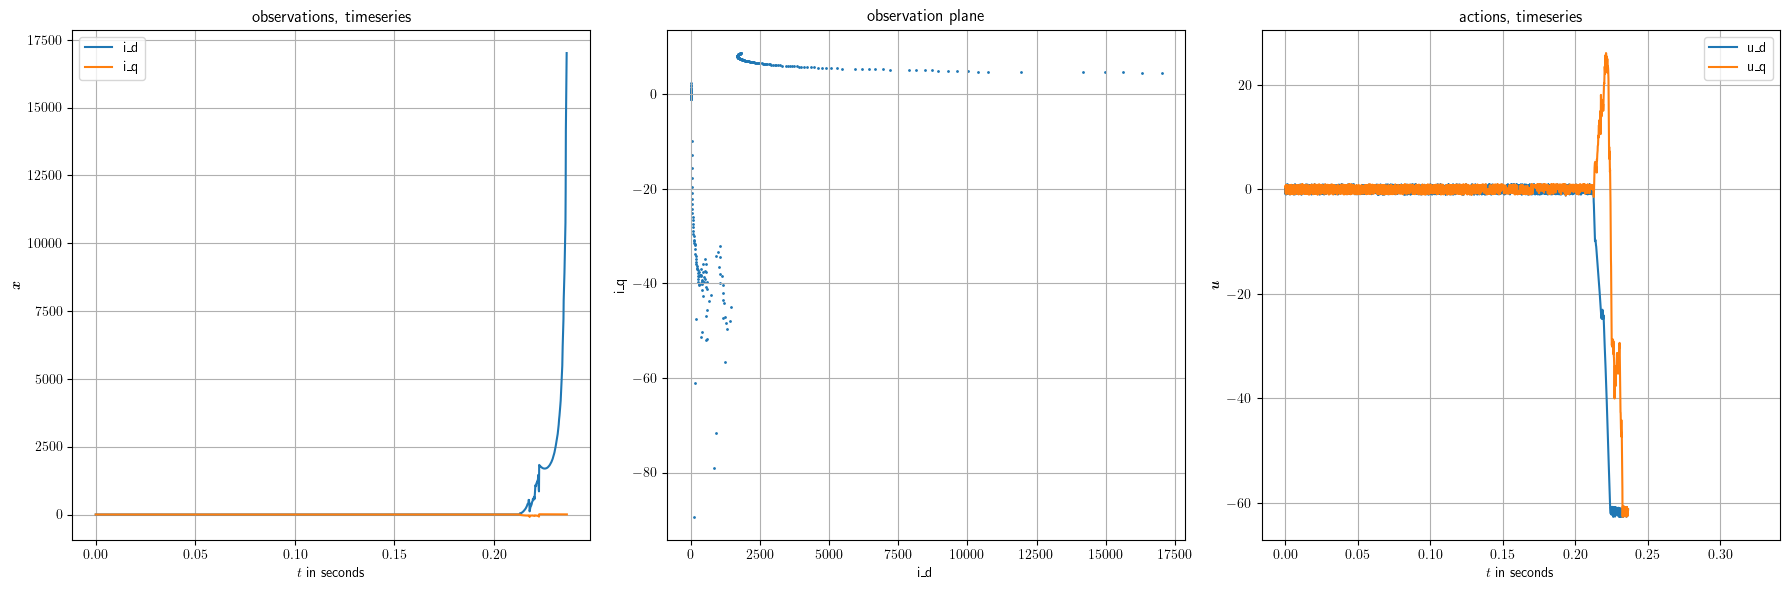

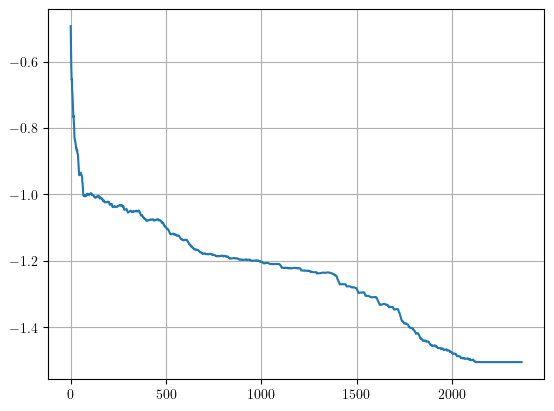

 22%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                        | 3371/15000 [07:04<24:23,  7.95it/s]


KeyboardInterrupt: 

In [12]:
default_dmpe(env, seed=1, plot_every=200)

In [44]:
env.LUT_interpolators["L_dd"](jnp.array([200,100]))

Array([0.00027671], dtype=float32)

In [ ]:
env.action_description

In [245]:
saturated_quants = [
    "L_dd",
    "L_dq",
    "L_qd",
    "L_qq",
    "Psi_d",
    "Psi_q",
]

i_max = 250

n_grid_points_y, n_grid_points_x = env.pmsm_lut[saturated_quants[0]].shape

x, y = np.linspace(-i_max, 0, n_grid_points_x), np.linspace(-i_max, i_max, n_grid_points_y)

In [246]:
LUT_interpolators = {
    q: jax.scipy.interpolate.RegularGridInterpolator(
        (x, y), env.pmsm_lut[q][:, :].T, method="linear", bounds_error=False, fill_value=None
    )
    for q in saturated_quants
}

In [253]:
n_points = n_grid_points_y * 1

test_x, test_y = np.linspace(-i_max, 0, n_points), np.linspace(-i_max, i_max, n_points)
xx, yy = jnp.meshgrid(test_x, test_y )
zz = jnp.concatenate([xx[..., None], yy[..., None]], axis=-1)


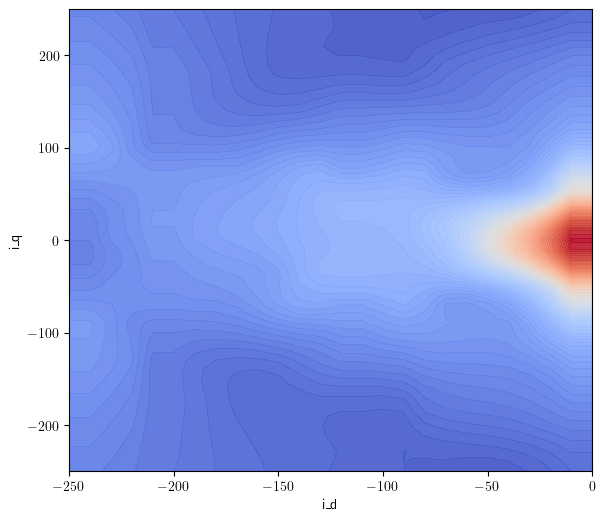

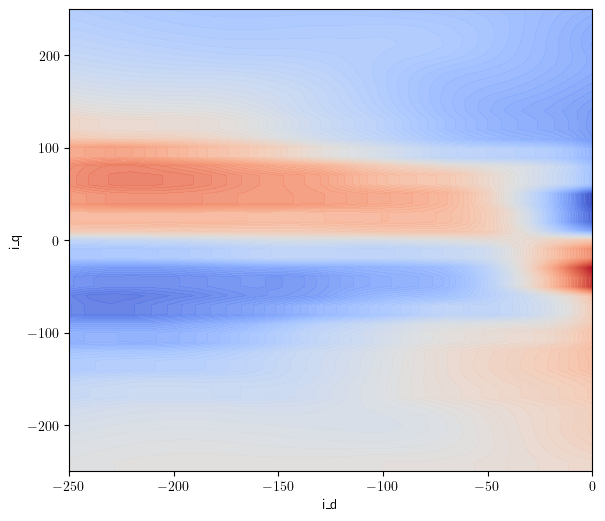

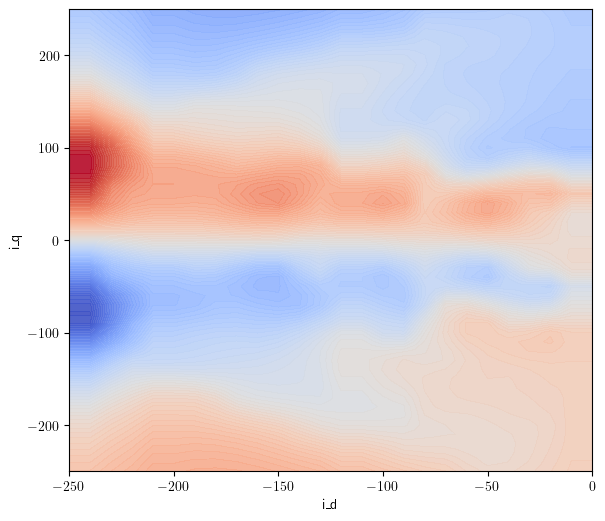

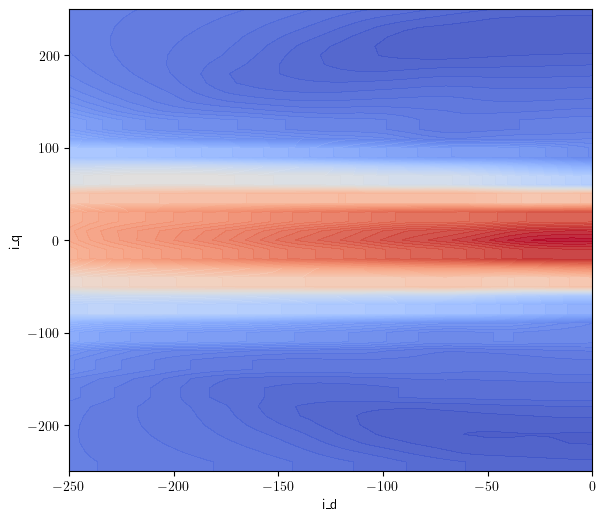

In [254]:
for q in saturated_quants[:4]:
    res = LUT_interpolators[q](zz.reshape(-1, 2))
    
    fig, axs = plt.subplots(figsize=(6.75, 6))
    
    cax = axs.contourf(
        zz[..., 0],
        zz[..., 1],
        res.reshape(n_points, n_points),
        antialiased=False,
        levels=100,
        alpha=0.9,
        cmap=plt.cm.coolwarm,
    )
    
    axs.set_xlabel(env.obs_description[0])
    axs.set_ylabel(env.obs_description[1])

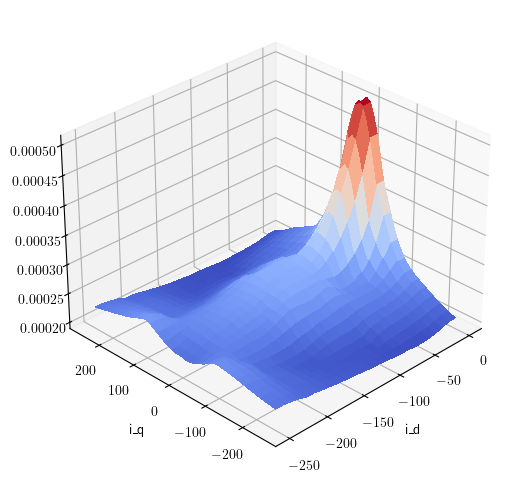

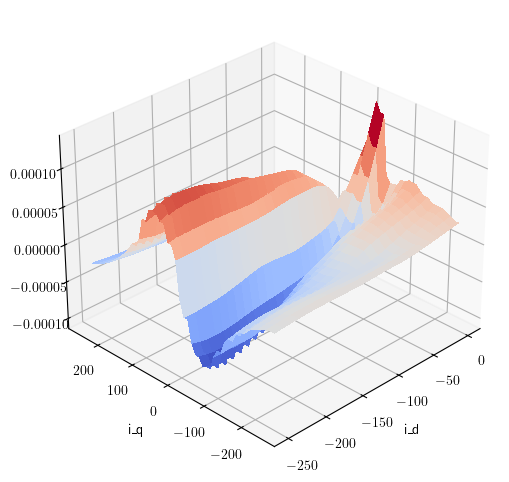

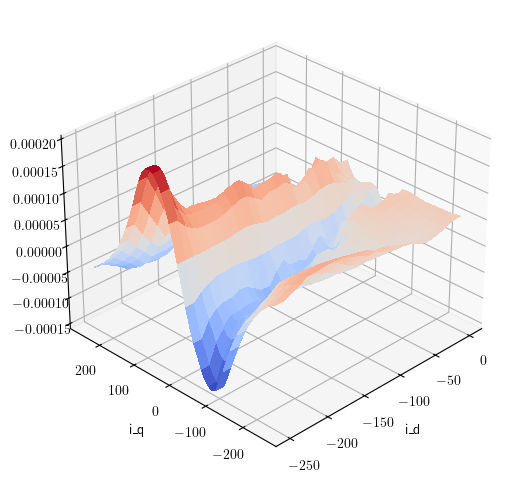

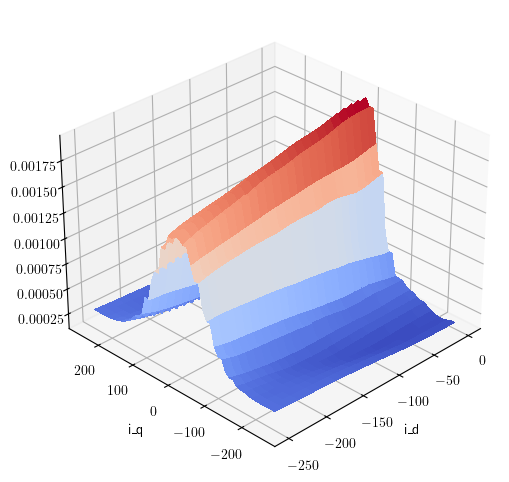

In [256]:
for q in saturated_quants[:4]:
    res = LUT_interpolators[q](zz.reshape(-1, 2))
    fig = plt.figure(figsize=(6, 6))
    axs = fig.add_subplot(111, projection="3d")
    
    _ = axs.plot_surface(
        zz[..., 0],
        zz[..., 1],
        res.reshape(n_points, n_points),
        antialiased=False,
        alpha=1,
        cmap=plt.cm.coolwarm,
    )
    
    axs.view_init(30,225)
    
    axs.set_xlabel(env.obs_description[0])
    axs.set_ylabel(env.obs_description[1])

In [261]:
for q in saturated_quants:
    print(env.pmsm_lut[q].shape)

(51, 26)
(51, 26)
(51, 26)
(51, 26)
(51, 26)
(51, 26)
